In [1]:
from openket import *
from scipy.integrate import odeint
from sympy import var, I
import numpy as np
import matplotlib.pyplot as plt
import math
import importlib

2025-11-27 02:16:12,362 - openket - INFO - openket v0.1.0 initialized successfully.


##### auxiliares

In [2]:
cmap = plt.cm.Accent
def plot_estados(rho_solution, estados):
    for i in estados:
        proyector = Ket(i,"atomo") * Bra(i,"atomo")
        prob_symb = sub_qexpr(qexpr=trace(rho*proyector, basis=base), dic=dic)
        prob = sym2num(sol=rho_solution, symbexpr=prob_symb)
        plt.plot(t, (np.abs(prob)), label=f'|{i}>', color=cmap(i), linewidth=2)
    plt.xlabel('tiempo [$1/Ω_0$]')
    plt.ylabel('probabilidad (estado del átomo)')
    plt.title(title, fontsize=12)
    plt.grid(True, color="gray", alpha=0.4)
    plt.legend()
    return plt

def plot_Ne(rho_solution):
    # definición simbólica de los observables
    N = aa * a # operador de número
    N_symb = sub_qexpr(qexpr=trace(rho * N, basis=base), dic=dic)
    N_expect = sym2num(sol=rho_solution, symbexpr=N_symb)
    plt.plot(t, np.real(N_expect), label='<N>', color=cmap(0))
    plt.title(title, fontsize=12)
    plt.xlabel('tiempo [$1/Ω_0$]')
    plt.ylabel('promedio de fotones (cavidad)')
    plt.legend()
    plt.grid()
    return plt

def plot_Xe(rho_solution):
    X = (1/np.sqrt(2)) * (a+aa) # cuadratura X adimensional
    X_symb = sub_qexpr(qexpr=trace(rho * X, basis=base), dic=dic)
    X_expect = sym2num(sol=rho_solution, symbexpr=X_symb)
    plt.plot(t, np.real(X_expect), label='<X>', color=cmap(0))
    plt.title(title, fontsize=12)
    plt.xlabel('tiempo [$1/Ω_0$]', fontsize=12)
    plt.ylabel('valor esperado posición', fontsize=12)
    plt.legend()
    plt.grid()
    return plt

def plot_Pe(rho_solution):
    P = (1/np.sqrt(2)) * I*(aa-a) # cuadratura P adimensional
    P_symb = sub_qexpr(qexpr=trace(rho * P, basis=base), dic=dic)
    P_expect = sym2num(sol=rho_solution, symbexpr=P_symb)
    plt.plot(t, np.real(P_expect), label='<P>', color=cmap(0))
    plt.title(title, fontsize=12)
    plt.xlabel('tiempo [$1/Ω_0$]', fontsize=12)
    plt.ylabel('valor esperado momento', fontsize=12)
    plt.legend()
    plt.grid()
    return plt

# cavidad con disipación y bombeo + átomo

In [4]:
nmax = 10 # truncación del espacio de Hilbert (número de estados de Fock)
dt = 1000
t = np.linspace(0, 15, dt)

base_cavidad = [Ket(i,"cavidad") for i in range(nmax)] # base de Fock para la cavidad
base_atomo = [Ket(0,"atomo"), Ket(1,"atomo")] # base de niveles de energía del átomo: 0=ground, 1=excited
base = [ket_a*ket_c for ket_a in base_atomo for ket_c in base_cavidad]
lenbase = len(base)

sigma_ge = Ket(0,"atomo") * Bra(1,"atomo") # operador de bajada átomico
sigma_eg = Ket(1,"atomo") * Bra(0,"atomo") # operador de subida atómico
sigma_gg = Ket(0,"atomo") * Bra(0,"atomo") # operador de nivel base
sigma_ee = Ket(1,"atomo") * Bra(1,"atomo") # operador de nivel excitado

hbar = 1.
g = 1. # constante de acoplamiento, mide qué tan fuerte es la interacción entre el átomo y un fotón en la cavidad
kappa = 1.0 # tasa de disipación de la cavidad
gamma = 0.5 # tasa de decaimiento espontáneo del átomo
rabi_b = 1.5 # intesidad del bombeo
rabi_l = 1.5 # intesidad del láser, proporcional a la amplitud del campo eléctrico del láser de control
detuning_bc = 0. # detuning entre frecuencia del bombeo y frecuencia de la cavidad
detuning_ca = 0. # detuning entre frecuencia de la cavidad y frecuencia del átomo
detuning_al = 0. # detuning entre frecuencia del átomo y frecuencia del láser de control

title = f"κ={kappa}; g={g}; Δ_bc={detuning_bc}; Δ_ca={detuning_ca}; Ω_rabi={rabi_b}"

rho = Operator("R")
a = AnnihilationOperator("cavidad", nmax-1)
aa = CreationOperator("cavidad", nmax-1)

##### sin decaimiento del átomo

In [4]:
H_cavidad = hbar * detuning_bc * (aa*a + 1/2) # Hamiltoniano del oscilador armónico cuántico (cavidad)
H_bombeo = I*hbar * rabi_b * (aa - a) # Hamiltoniano del bombeo
H_atomo = (hbar/2) * detuning_ca * (sigma_ee - sigma_gg) # Hamiltoniano del átomo libre (RWA)
H_atomo_laser = -(hbar/2) * rabi_l * (sigma_ge + sigma_eg) # Hamiltoniano de interacción átomo-láser (RWA)
H_atomo_cavidad = hbar * g * (aa*sigma_ge + a*sigma_eg) # Hamiltoniano de la interacción átomo-cavidad (jaynes-cummings) (RWA)

# Hamiltoniano total
H = H_cavidad + H_bombeo + H_atomo + H_atomo_laser + H_atomo_cavidad
# ecuación de movimiento de Lindblad
rdot = I/hbar * comm(H,rho) + (kappa/2)*(2*a*rho*aa - aa*a*rho - rho*aa*a)

In [6]:
build_ode(rho=rho, rdot=rdot, basis=base, filetype="Scipy", filename="func.py")

In [5]:
from func import dic, f
# convertir condiciones iniciales simbólicas -> numéricas
nfotones0 = 0 # número promedio de fotones iniciales dentro de la cavidad
nestado0 = 0 # estado inicial del átomo
ket0 = Ket(nfotones0,"cavidad") * Ket(nestado0,"atomo")
rho0 = ket0*dag(ket0)
init_conditions = init_state(rho=rho, rho0=rho0, basis=base, dic=dic)
# solución numérica
rho_solution = odeint(f, init_conditions, t)

<module 'matplotlib.pyplot' from '/home/ultrxvioletx/venv/openket/lib/python3.13/site-packages/matplotlib/pyplot.py'>

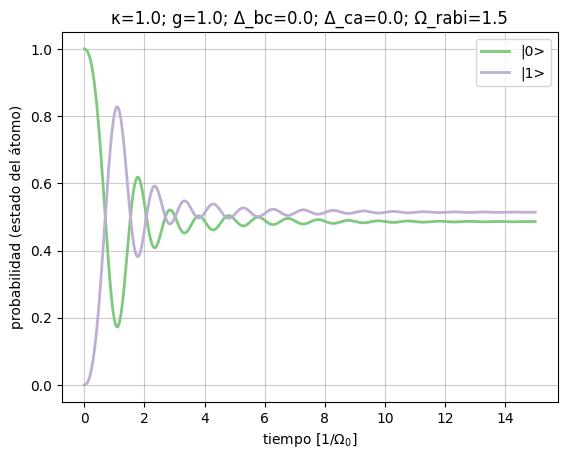

In [6]:
estados = [0,1]
plot_estados(rho_solution, estados)

<module 'matplotlib.pyplot' from '/home/ultrxvioletx/venv/openket/lib/python3.13/site-packages/matplotlib/pyplot.py'>

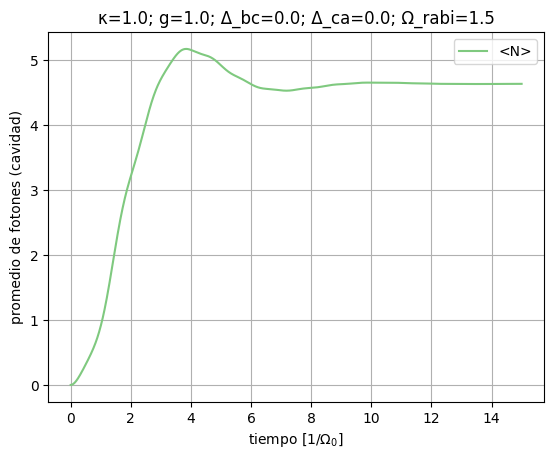

In [7]:
plot_Ne(rho_solution)

##### posición y momento

<module 'matplotlib.pyplot' from '/home/ultrxvioletx/venv/openket/lib/python3.13/site-packages/matplotlib/pyplot.py'>

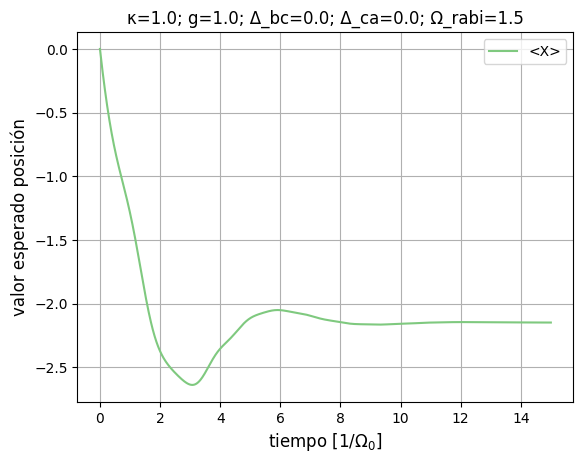

In [8]:
plot_Xe(rho_solution)

<module 'matplotlib.pyplot' from '/home/ultrxvioletx/venv/openket/lib/python3.13/site-packages/matplotlib/pyplot.py'>

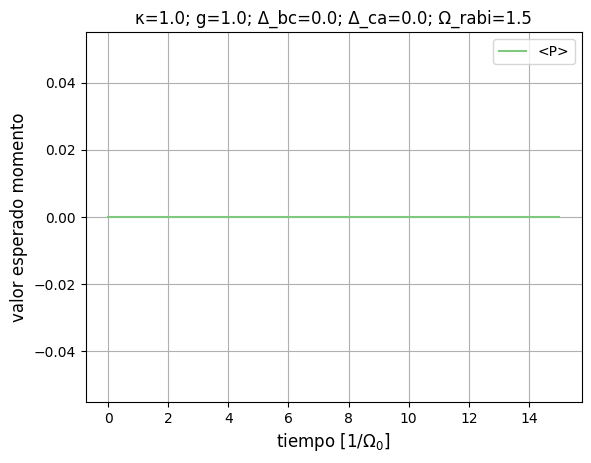

In [9]:
plot_Pe(rho_solution)

# + decaimiento espontáneo del átomo

In [5]:
H_cavidad = hbar * detuning_bc * (aa*a + 1/2) # Hamiltoniano del oscilador armónico cuántico (cavidad)
H_bombeo = I*hbar * rabi_b * (aa - a) # Hamiltoniano del bombeo
H_atomo = (hbar/2) * detuning_ca * (sigma_ee - sigma_gg) # Hamiltoniano del átomo libre (RWA)
H_atomo_laser = -(hbar/2) * rabi_l * (sigma_ge + sigma_eg) # Hamiltoniano de interacción átomo-láser (RWA)
H_atomo_cavidad = hbar * g * (aa*sigma_ge + a*sigma_eg) # Hamiltoniano de la interacción átomo-cavidad (jaynes-cummings) (RWA)

# Hamiltoniano total
H = H_cavidad + H_bombeo + H_atomo + H_atomo_laser + H_atomo_cavidad
# ecuación de movimiento de Lindblad
rdot = I/hbar * comm(H,rho) \
        + (kappa/2)*(2*a*rho*aa - aa*a*rho - rho*aa*a) \
        + (gamma/2)*(2*sigma_ge*rho*sigma_eg - sigma_eg*sigma_ge*rho - rho*sigma_eg*sigma_ge)

In [11]:
build_ode(rho=rho, rdot=rdot, basis=base, filetype="Scipy", filename="func.py")

In [6]:
from func import dic, f
# convertir condiciones iniciales simbólicas -> numéricas
nfotones0 = 0 # número promedio de fotones iniciales dentro de la cavidad
nestado0 = 0 # estado inicial del átomo
ket0 = Ket(nfotones0,"cavidad") * Ket(nestado0,"atomo")
rho0 = ket0*dag(ket0)
init_conditions = init_state(rho=rho, rho0=rho0, basis=base, dic=dic)
# solución numérica
rho_solution = odeint(f, init_conditions, t)

<module 'matplotlib.pyplot' from '/home/ultrxvioletx/venv/openket/lib/python3.13/site-packages/matplotlib/pyplot.py'>

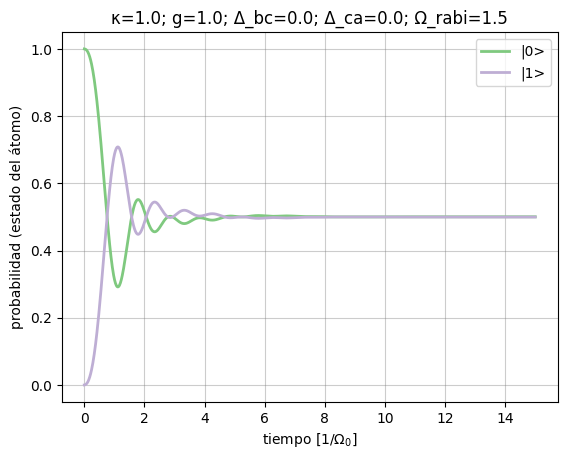

In [7]:
estados = [0,1]
plot_estados(rho_solution, estados)

<module 'matplotlib.pyplot' from '/home/ultrxvioletx/venv/openket/lib/python3.13/site-packages/matplotlib/pyplot.py'>

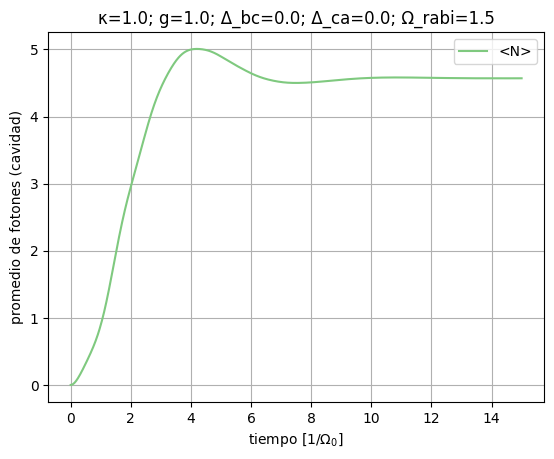

In [8]:
plot_Ne(rho_solution)

#### posición y momento

<module 'matplotlib.pyplot' from '/home/ultrxvioletx/venv/openket/lib/python3.13/site-packages/matplotlib/pyplot.py'>

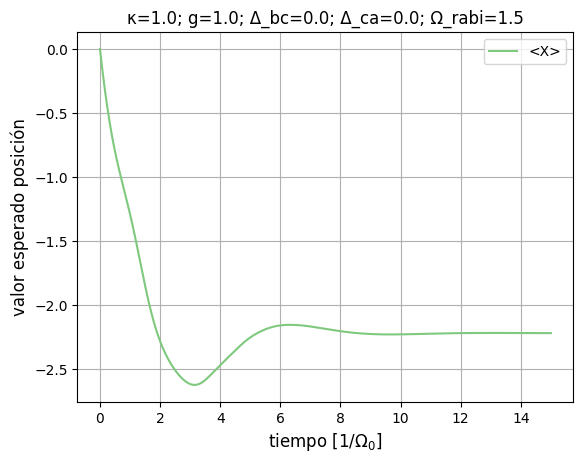

In [9]:
plot_Xe(rho_solution)

<module 'matplotlib.pyplot' from '/home/ultrxvioletx/venv/openket/lib/python3.13/site-packages/matplotlib/pyplot.py'>

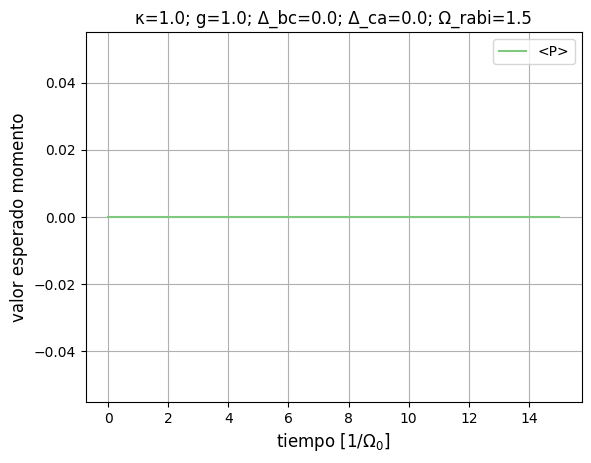

In [10]:
plot_Pe(rho_solution)